In [1]:
# Cell 1: 라이브러리 & 설정
import os
import json
import re
import torch
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# 설정값
INPUT_FILE = "project_full_context.txt"
OUTPUT_JSON = "project_flows.json"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 실행 환경: {device.upper()}")

c:\Pyg\Projects\semi\yuzyproject-aimodels\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 실행 환경: CUDA


In [ ]:
# [Cell 2] 경량화 모델 로더 (3B급)

# ==============================
# 사용하고 싶은 모델 하나만 주석 해제
# ==============================

# 1. [Microsoft] Phi-3.5 (3.8B) - 긴 코드 분석에 최강 (128k 컨텍스트)
MODEL_ID = "microsoft/Phi-3.5-mini-instruct"

# 2. [IBM] Granite 3.0 (3B MoE) - 속도가 가장 빠름 (코딩 특화)
# MODEL_ID = "ibm-granite/granite-3.0-3b-a800m-instruct"

# 3. [Meta] Llama 3.2 (3B) - 한국어/설명 능력이 좋음 (*허깅페이스 로그인 필수*)
# MODEL_ID = "meta-llama/Llama-3.2-3B-Instruct"

# 4. [Google] Gemma 2 (2B) - 가장 가벼움
# MODEL_ID = "google/gemma-2-2b-it"

print(f"🔄 모델 로딩 시작... ({MODEL_ID})")

# 4비트 양자화 설정 (메모리 절약)
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        quantization_config=quantization_config,
        device_map="auto",
        trust_remote_code=False  # Meta 모델의 경우 필요
    )
    print(f"✅ ({MODEL_ID}) 모델 장착 완료! (4-bit 가속 모드)")
except Exception as e:
    print(f"❌ 모델 로드 실패: {e}")

🔄 모델 로딩 시작... (microsoft/Phi-3.5-mini-instruct)


`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.
Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it]


✅ (microsoft/Phi-3.5-mini-instruct) 모델 장착 완료! (4-bit 가속 모드)


In [3]:
# Cell 3: 프롬프트 정의 (초보자 멘토링 & 데이터 흐름 추적 강화)
SYSTEM_PROMPT = """
You are a 'Senior Coding Mentor' for beginners.
Your goal is to visualize the **Lifecycle of Data** and **Execution Flow** across multiple files.

### YOUR TASK
1.  **Trace the Data**: If a user clicks 'Signup', follow the variables (id, password, etc.) from the Router -> Controller -> Service -> Database.
2.  **Explain the 'Return'**: Beginners struggle to understand what comes back from a function. Explicitly state what is returned (e.g., "Returns a User Object" or "Returns a True/False flag").
3.  **Beginner-Friendly Logic**: Don't just say "Hash password". Say "Security Step: We convert the plain password into a scrambled code (Hash) so hackers can't read it."

### OUTPUT FORMAT (JSON ONLY)
{
  "project_summary": "A high-level summary of how the files interact (e.g., App.js sets up the server, AuthRouter handles login...)",
  "flows": [
    {
      "flow_name": "User Signup Process (Data Flow)",
      "sequence": [
        {
          "step": 1,
          "file_context": "Where are we?",
          "from": {
            "file": "router/auth.js",
            "code_snippet": "router.post('/signup', ...)",
            "focus_word": "signup"
          },
          "to": {
            "file": "controller/authController.js",
            "code_snippet": "export async function signup(req, res)...",
            "focus_word": "signup"
          },
          "data_transferred": "req.body (userid, password)",
          "beginner_explanation": "1. The Router receives the user's data. 2. It passes the data to the Controller's 'signup' function to handle the logic."
        },
        {
          "step": 2,
          "file_context": "Logic Processing",
          "from": {
            "file": "controller/authController.js",
            "code_snippet": "const user = await authRepository.createUser(...)",
            "focus_word": "createUser"
          },
          "to": {
            "file": "data/authRepository.js",
            "code_snippet": "export async function createUser(user) { ... }",
            "focus_word": "createUser"
          },
          "data_transferred": "User Info Object",
          "beginner_explanation": "The Controller asks the Repository to save the new user to the Database. It waits (await) for the database to finish.",
          "return_expected": "The created User ID"
        }
      ]
    }
  ]
}

### RULES
1. **JSON ONLY**. No markdown.
2. `code_snippet` must be EXACT.
3. Identify **Cross-File** calls (e.g., Controller calling Service/Repository).
"""

CHUNK_PROMPT = """
Context: {user_query}
Analyze the following code file. Does it contain part of the requested flow?
If yes, extract the call relationships.

File Name: {filename}
Code Content: {code_snippet}

### OUTPUT STRICT RULES
- You MUST output ONLY the JSON object. Nothing else.
- Do NOT include markdown code fences.
- Do NOT include explanations before or after the JSON.
- Start with { and end with }
"""

print("✅ 프롬프트 정의 완료 (멘토링 모드)")

✅ 프롬프트 정의 완료 (멘토링 모드)


In [4]:
# Cell 4: 분석 함수 (청크)
def analyze_chunk(filename, code_snippet, user_query):
    """
    개별 파일/청크를 LLM으로 분석
    """
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {
            "role": "user",
            "content": CHUNK_PROMPT.format(
                filename=filename,
                code_snippet=code_snippet[:3000],
                user_query=user_query
            )
        }
    ]

    text_input = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    model_inputs = tokenizer([text_input], return_tensors="pt").to(device)

    print(f"  🔍 분석 중: {filename}")

    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=1024,
        temperature=0.1,
        top_p=0.95,
        do_sample=False
    )

    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    clean_text = response_text.strip()
    clean_text = re.sub(r"^```(json)?", "", clean_text, flags=re.MULTILINE).strip()
    clean_text = re.sub(r"```$", "", clean_text, flags=re.MULTILINE).strip()

    try:
        result = json.loads(clean_text)
        flows = result.get("flows", [])
        print(f"    ✅ {len(flows)}개 flow 발견")
        return result
    except json.JSONDecodeError as e:
        print(f"    ⚠️ JSON 파싱 실패")
        return {"flows": []}

print("✅ analyze_chunk 함수 정의 완료")

✅ analyze_chunk 함수 정의 완료


In [5]:
# Cell 5: 파일 분할 및 분석 로직 (강력한 파싱 적용)
def parse_files_from_context(code_context):
    """
    다양한 형태의 파일 헤더를 인식하여 파일을 분리합니다.
    """
    files = {}
    patterns = [
        r"===\s*FILE_PATH:\s*(.+?)\s*===",
        r"###\s*FILE:\s*(.+)",
        r"File:\s*(.+)"
    ]
    
    lines = code_context.split('\n')
    current_file = "unknown_source"
    current_content = []
    
    for line in lines:
        is_header = False
        for pat in patterns:
            match = re.search(pat, line)
            if match:
                if current_content:
                    files[current_file] = "\n".join(current_content).strip()
                
                current_file = match.group(1).strip()
                current_content = []
                is_header = True
                break
        
        if not is_header:
            current_content.append(line)
            
    if current_content:
        files[current_file] = "\n".join(current_content).strip()
        
    return files

def analyze_code_flow_chunked(user_query):
    if not os.path.exists(INPUT_FILE):
        print(f"❌ '{INPUT_FILE}' 파일이 없습니다.")
        return False

    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        code_context = f.read()

    files = parse_files_from_context(code_context)
    print(f"📂 파싱된 파일 개수: {len(files)}개")
    for fname in files.keys():
        print(f"  - {fname}")
    
    combined_context = ""
    for fname, content in files.items():
        if len(content) > 2000:
            content = content[:2000] + "\n... (truncated)"
        combined_context += f"\n=== FILE: {fname} ===\n{content}\n"

    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": f"User Query: {user_query}\n\nCodebase:\n{combined_context}"}
    ]
    
    print(f"🧠 AI 멘토가 '{user_query}' 흐름을 분석 중입니다...")
    
    text_input = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    model_inputs = tokenizer([text_input], return_tensors="pt").to(device)
    
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=2048,
        temperature=0.1,
        do_sample=True
    )
    
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    # JSON 정제 (강화 버전)
    clean_text = response_text.strip()
    
    # 마크다운 코드블록 제거
    clean_text = re.sub(r"```json\n?", "", clean_text)
    clean_text = re.sub(r"```\n?", "", clean_text)
    clean_text = re.sub(r"^```", "", clean_text, flags=re.MULTILINE)
    clean_text = re.sub(r"```$", "", clean_text, flags=re.MULTILINE)
    
    # 앞뒤 공백 제거
    clean_text = clean_text.strip()
    
    # JSON 시작 전 텍스트 제거
    json_start = clean_text.find('{')
    if json_start > 0:
        clean_text = clean_text[json_start:]
    
    # JSON 끝 후 텍스트 제거
    json_end = clean_text.rfind('}')
    if json_end > 0:
        clean_text = clean_text[:json_end+1]
    
    print(f"📝 정제된 응답 (첫 200자): {clean_text[:200]}")
    
    try:
        json_data = json.loads(clean_text)
        with open(OUTPUT_JSON, 'w', encoding='utf-8') as f:
            json.dump(json_data, f, ensure_ascii=False, indent=2)
        print(f"✅ 분석 완료! JSON 저장됨: {OUTPUT_JSON}")
        return True
    except json.JSONDecodeError as e:
        print(f"❌ JSON 파싱 실패: {e}")
        print(f"파싱 시도한 텍스트:\n{clean_text[:300]}")
        with open("debug_response.txt", "w", encoding="utf-8") as f:
            f.write(clean_text)
        return False

print("✅ Cell 5 (분석 로직) 강화 완료")

✅ Cell 5 (분석 로직) 강화 완료


In [6]:
# Cell 6: 초보자 친화적 시각화 (설명 강화 버전)
def visualize_education_style():
    if not os.path.exists(OUTPUT_JSON):
        return None

    try:
        with open(OUTPUT_JSON, 'r', encoding='utf-8') as f:
            data = json.load(f)
            flows = data.get("flows", [])
            summary = data.get("project_summary", "프로젝트 흐름도")
    except:
        return None

    if not flows: return None

    # 캔버스 설정
    img_width = 1400
    total_steps = sum(len(f.get('sequence', [])) for f in flows)
    img_height = max(800, total_steps * 350 + 300) # 높이 넉넉하게
    
    img = Image.new('RGB', (img_width, img_height), color='#1e1e1e')
    draw = ImageDraw.Draw(img)
    
    try:
        font_title = ImageFont.truetype("arialbd.ttf", 24)
        font_code = ImageFont.truetype("consola.ttf", 14)
        font_desc = ImageFont.truetype("arial.ttf", 16)
        font_file = ImageFont.truetype("arialbd.ttf", 16)
    except:
        font_title = ImageFont.load_default()
        font_code = ImageFont.load_default()
        font_desc = ImageFont.load_default()
        font_file = ImageFont.load_default()

    y = 50
    # 1. 전체 프로젝트 요약 표시
    draw.text((50, y), f"📚 Project Summary: {summary}", fill="#FFD700", font=font_title)
    y += 60

    for flow in flows:
        flow_name = flow.get('flow_name', 'Process Flow')
        draw.rectangle([30, y, img_width-30, y+40], fill="#444444")
        draw.text((50, y+8), f"🔄 Flow: {flow_name}", fill="#FFFFFF", font=font_title)
        y += 70

        sequence = flow.get('sequence', [])
        for step in sequence:
            # 정보 추출
            f_file = step['from'].get('file', 'Unknown File')
            t_file = step['to'].get('file', 'Unknown File')
            f_code = step['from'].get('code_snippet', '').strip()
            t_code = step['to'].get('code_snippet', '').strip()
            
            explanation = step.get('beginner_explanation', '')
            data_info = step.get('data_transferred', '')
            return_info = step.get('return_expected', '')

            # --- [Step Box] ---
            # 왼쪽 (Caller)
            draw.rectangle([50, y, 600, y+120], fill="#252526", outline="#007acc", width=2)
            draw.text((60, y+10), f"📄 {f_file}", fill="#569cd6", font=font_file)
            draw.text((60, y+40), f_code[:180], fill="#d4d4d4", font=font_code)
            
            # 오른쪽 (Callee)
            draw.rectangle([800, y, 1350, y+120], fill="#252526", outline="#ce9178", width=2)
            draw.text((810, y+10), f"📄 {t_file}", fill="#ce9178", font=font_file)
            draw.text((810, y+40), t_code[:180], fill="#d4d4d4", font=font_code)

            # --- [화살표 & 데이터] ---
            # 화살표
            draw.line([(600, y+60), (800, y+60)], fill="#FFFFFF", width=3)
            draw.polygon([(800, y+60), (790, y+50), (790, y+70)], fill="#FFFFFF")
            
            # 데이터 이동 정보
            if data_info:
                draw.text((620, y+35), f"📦 {data_info}", fill="#4ec9b0", font=font_desc)

            # --- [초보자용 설명 영역] ---
            y += 130
            draw.rectangle([100, y, 1300, y+90], fill="#2d2d30", outline="#FFD700", width=1)
            
            # 설명 텍스트
            draw.text((120, y+10), f"💡 멘토의 설명: {explanation}", fill="#FFFFFF", font=font_desc)
            if return_info:
                draw.text((120, y+45), f"↩️ 예상 리턴값: {return_info}", fill="#da70d6", font=font_desc)

            y += 120 # 다음 스텝 간격

        y += 50

    return img

print("✅ Cell 6 (교육용 시각화) 수정 완료")

✅ Cell 6 (교육용 시각화) 수정 완료


In [7]:
# Cell 7: 코드 분석 실행 (JSON + 텍스트 설명)
print("🚀 청크 기반 분석 시작...")
success = analyze_code_flow_chunked(user_query="코드의 함수 호출 흐름")

if success:
    with open(OUTPUT_JSON, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    print("\n === 추출된 흐름 (JSON) ===\n")
    print(json.dumps(data, ensure_ascii=False, indent=2))
    
    print(f"\n✅ JSON 저장 완료: {OUTPUT_JSON}")
    print(f"📊 총 {data.get('total_flows', 0)}개 flow 발견")
    
    for idx, flow in enumerate(data.get('flows', []), 1):
        print(f"\n[Flow {idx}] {flow.get('flow_name', 'Unknown')}")
        print(f"  파일: {flow.get('source_file', 'Unknown')}")
        sequence = flow.get('sequence', [])
        print(f"  단계: {len(sequence)}개")
        for step in sequence:
            if not isinstance(step, dict):
                print("    ⚠️ 잘못된 step 형식(딕셔너리 아님), 스킵합니다.")
                continue

            from_obj = step.get('from') or {}
            to_obj = step.get('to') or {}
            if not isinstance(from_obj, dict):
                from_obj = {}
            if not isinstance(to_obj, dict):
                to_obj = {}
            from_word = from_obj.get('focus_word') or from_obj.get('file') or '?'
            to_word = to_obj.get('focus_word') or to_obj.get('file') or '?'
            desc = step.get('description') or step.get('beginner_explanation') or ''
            print(f"    → {from_word} → {to_word}: {desc}")
else:
    print("❌ 분석 실패")

🚀 청크 기반 분석 시작...
📂 파싱된 파일 개수: 13개
  - unknown_source
  - C:\Pyg\X\Server\app.mjs
  - C:\Pyg\X\Server\config.mjs
  - C:\Pyg\X\Server\package.json
  - C:\Pyg\X\Server\controller\auth.mjs
  - C:\Pyg\X\Server\controller\post.mjs
  - C:\Pyg\X\Server\data\auth.mjs
  - C:\Pyg\X\Server\data\post.mjs
  - C:\Pyg\X\Server\db\database.mjs
  - C:\Pyg\X\Server\middleware\auth.mjs
  - C:\Pyg\X\Server\middleware\validator.mjs
  - C:\Pyg\X\Server\router\auth.mjs
  - C:\Pyg\X\Server\router\posts.mjs
🧠 AI 멘토가 '코드의 함수 호출 흐름' 흐름을 분석 중입니다...


AttributeError: 'DynamicCache' object has no attribute 'seen_tokens'

🎨 시각화 시작...


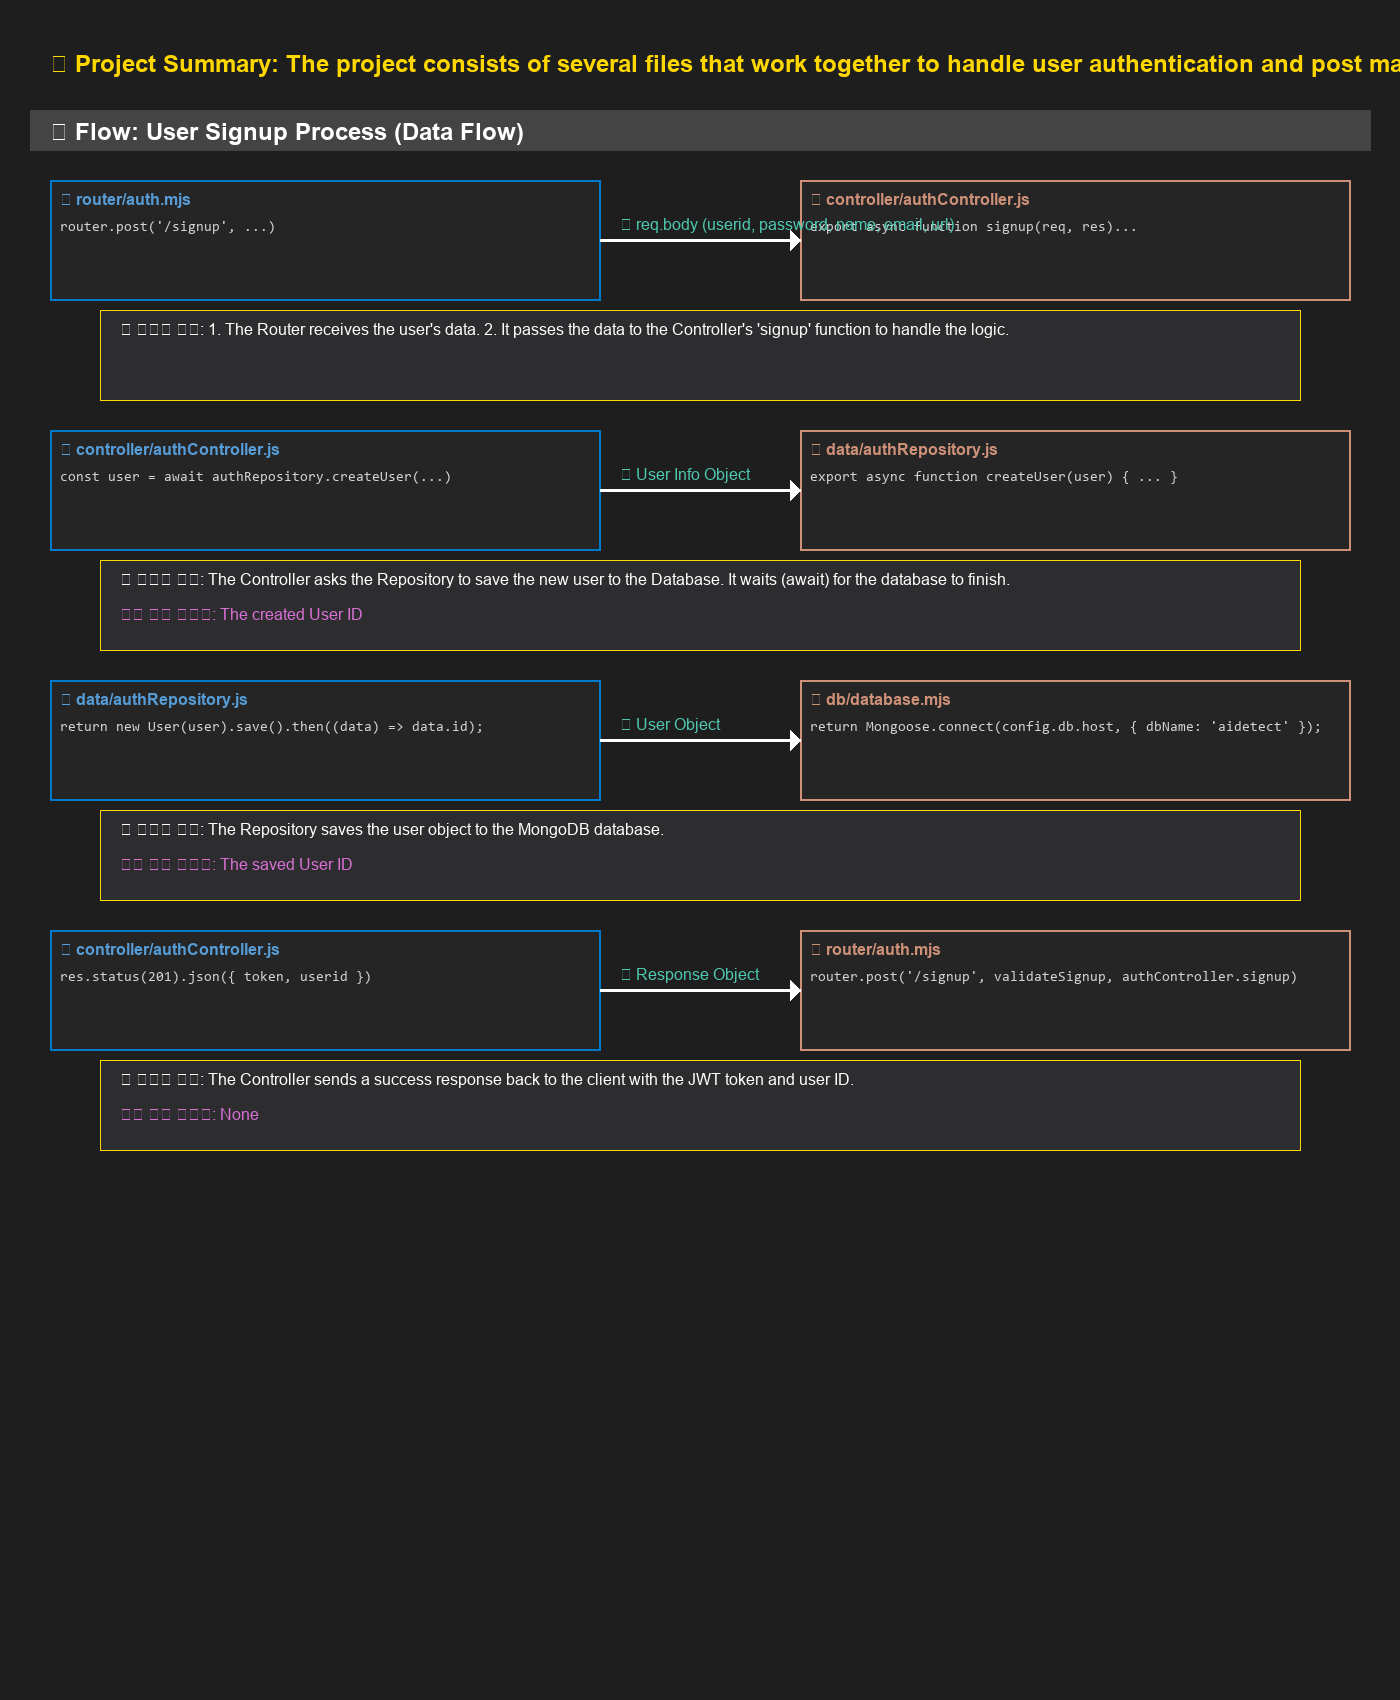

✨ 교육용 흐름도 저장 완료!


In [9]:
# Cell 8: 실행
print("🎨 시각화 시작...")
result_img = visualize_education_style()

if result_img:
    display(result_img)
    result_img.save("final_education_flow.png")
    print("✨ 교육용 흐름도 저장 완료!")
else:
    print("❌ 시각화 생성 실패")

In [8]:
# Cell 7-1: 디버깅 - LLM 응답 확인
print("🔍 디버깅: LLM 응답 상태 확인")

if os.path.exists("debug_response.txt"):
    with open("debug_response.txt", 'r', encoding='utf-8') as f:
        response = f.read()
    print("=== LLM 원본 응답 (첫 1000자) ===")
    print(response[:1000])
    print("\n=== 응답 끝부분 ===")
    print(response[-500:])
else:
    print("❌ debug_response.txt 파일이 없습니다. Cell 7을 먼저 실행하세요.")

🔍 디버깅: LLM 응답 상태 확인
=== LLM 원본 응답 (첫 1000자) ===
{
  "project_summary": "This project is a Node.js application using Express.js for routing, MongoDB with Mongoose for ORM, and JWT for authentication. The application has two main parts: handling user authentication (signup, login, and protected routes) and managing blog posts (creating, reading, updating, and deleting).",
  "flows": [
    {
      "flow_name": "User Signup Process (Data Flow)",
      "sequence": [
        {
          "step": 1,
          "file_context": "Router receives the request",
          "from": {
            "file": "router/auth.mjs",
            "code_snippet": "router.post('/signup', validateSignup, authController.signup);",
            "focus_word": "signup"
          },
          "to": {
            "file": "controller/auth.mjs",
            "code_snippet": "export async function signup(req, res, next) {...}",
            "focus_word": "signup"
          },
          "data_transferred": "req.body (userid, passw